In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from pandas.plotting import autocorrelation_plot
import requests
import collections

To start working on the BitFinex data, I first have to pull the data from Quandl.  Since the data is nested, I can't just use pd.read_json(), and instead will use the json library to put it in a more manageable form.

In [2]:
#import the data itself
API_KEY = ''

raw_json = requests.get('https://www.quandl.com/api/v3/datasets/BITFINEX/IOTUSD.json?api_key=' + API_KEY).json()
    
column_names = raw_json['dataset']['column_names']
raw_data = pd.DataFrame(data=raw_json['dataset']['data'], columns=column_names)

print(raw_data.head())

         Date     High      Low       Mid     Last      Bid      Ask  \
0  2021-06-27  0.79729  0.74141  0.779180  0.77800  0.77889  0.77947   
1  2021-06-26  0.79172  0.72787  0.766475  0.76554  0.76647  0.76648   
2  2021-06-25  0.85290  0.75497  0.756035  0.75664  0.75544  0.75663   
3  2021-06-24  0.84080  0.74471  0.816770  0.81872  0.81585  0.81769   
4  2021-06-23  0.83149  0.68397  0.779140  0.77970  0.77846  0.77982   

         Volume  
0  1.657688e+06  
1  2.259150e+06  
2  3.157057e+06  
3  3.684050e+06  
4  6.941646e+06  


In [3]:
#check dtypes, check for null/weird values
print(raw_data.dtypes)

Date       object
High      float64
Low       float64
Mid       float64
Last      float64
Bid       float64
Ask       float64
Volume    float64
dtype: object


In [4]:
print(raw_data.describe())
print('')
print(raw_data[raw_data.isna()].count())

              High          Low          Mid         Last          Bid  \
count  1438.000000  1438.000000  1438.000000  1438.000000  1438.000000   
mean      0.753601     0.656738     0.708466     0.708442     0.707923   
std       0.823877     0.680274     0.756268     0.756194     0.755867   
min       0.124290     0.075506     0.107810     0.108230     0.107650   
25%       0.276783     0.256833     0.267694     0.268007     0.267443   
50%       0.384850     0.345300     0.368138     0.367775     0.367410   
75%       1.010850     0.887055     0.960809     0.961815     0.960700   
max       5.800000     4.511100     5.314400     5.319000     5.310000   

               Ask        Volume  
count  1438.000000  1.438000e+03  
mean      0.709010  1.020452e+07  
std       0.756669  1.707673e+07  
min       0.107970  2.363083e+05  
25%       0.267910  2.460280e+06  
50%       0.368925  5.190596e+06  
75%       0.961753  1.167930e+07  
max       5.318800  2.197782e+08  

Date      0
High 

It looks like the numeric columns are not normally distributed, as expected, and there are no null values or zero/negative values.

In [5]:
#add/alter appropriate columns for the data
new_df = raw_data

new_df['Date'] = pd.to_datetime(raw_data['Date'])
new_df['Year'] = new_df['Date'].apply(lambda x: x.year-2000)
new_df['Month'] = new_df['Date'].apply(lambda x: x.month)
new_df['Day'] = new_df['Date'].apply(lambda x: x.day)

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
new_df['Weekday'] = new_df['Date'].apply(lambda x: weekdays[x.weekday()])
new_df['Volume'] = new_df['Volume'].apply(lambda x: np.log(x)) #scaled so it doesn't have to include exponents
new_df.sort_values(by='Date', ascending=True, inplace=True)
new_df.set_index('Date', inplace=True)
print(new_df.head())

               High      Low       Mid     Last      Bid      Ask     Volume  \
Date                                                                           
2017-06-13  1.30000  0.41000  0.595810  0.59773  0.59400  0.59762  16.000992   
2017-06-14  0.61010  0.47948  0.509245  0.50639  0.50639  0.51210  15.950432   
2017-06-15  0.54470  0.29123  0.367650  0.36600  0.36600  0.36930  15.675398   
2017-06-16  0.59900  0.30530  0.415355  0.41540  0.41531  0.41540  15.422886   
2017-06-17  0.45116  0.39000  0.432555  0.43210  0.43210  0.43301  14.310691   

            Year  Month  Day    Weekday  
Date                                     
2017-06-13    17      6   13    Tuesday  
2017-06-14    17      6   14  Wednesday  
2017-06-15    17      6   15   Thursday  
2017-06-16    17      6   16     Friday  
2017-06-17    17      6   17   Saturday  


Oddly enough this stock data seems to include weekends, despite stocks being closed then.  From researching about stocks, I've learned that Bid is the minimum selling price the average person will settle for, Ask is maximum buying price someone will settle for, and Volume is the number of trades for that day.  While I wanted to be able to predict closing price from starting price, I may have to predict off of the previous days' values, as there is a closing price column (Last) but not an opening price column.

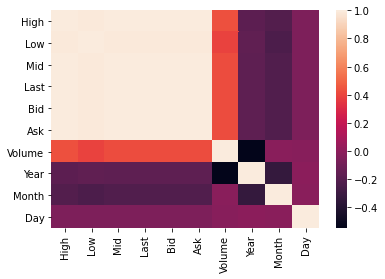

In [6]:
#check for correlations
sns.heatmap(new_df.corr())
plt.show()

Looking at the above heatmap:
Low, Mid, High, Last, Bid, and Ask all seem to be very strongly correlated.
Year, Month, and Day have little to negative correlation with everything since they're basically categorical, 
but Year has a medium negative correlation with Volume, which implies that less people have been trading as the years go on.

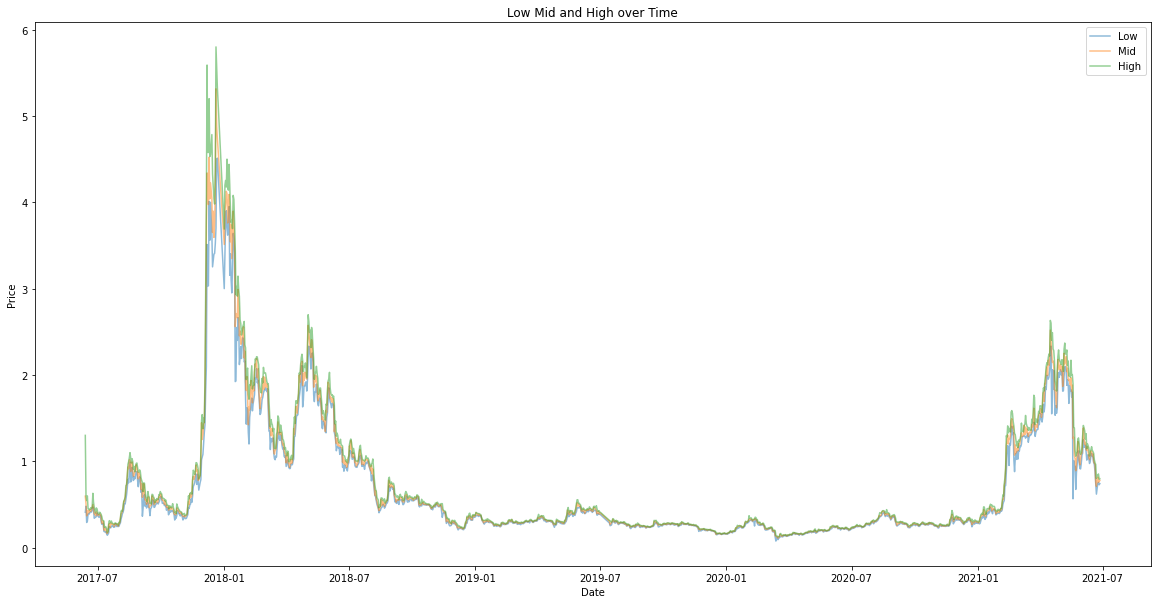

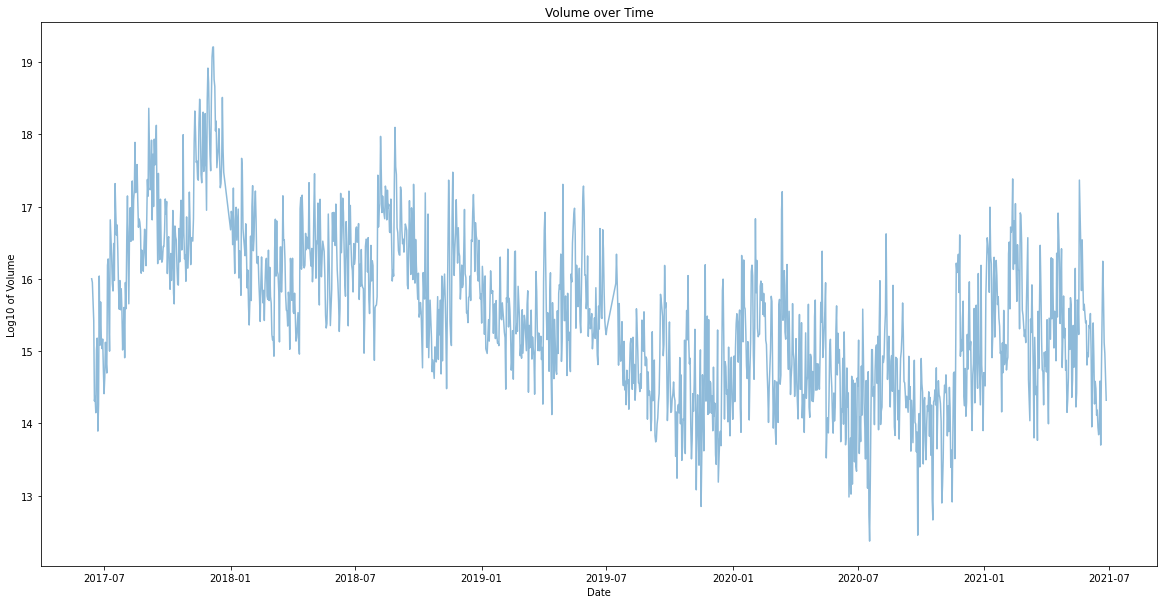

In [7]:
plt.figure(figsize=(20, 10))
plt.plot('Low', data=new_df, alpha=0.5)
plt.plot('Mid', data=new_df, alpha=0.5)
plt.plot('High', data=new_df, alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Low Mid and High over Time')
plt.show()

plt.figure(figsize=(20, 10))
plt.plot('Volume', data=new_df, alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Log10 of Volume')
plt.title('Volume over Time')
plt.show()

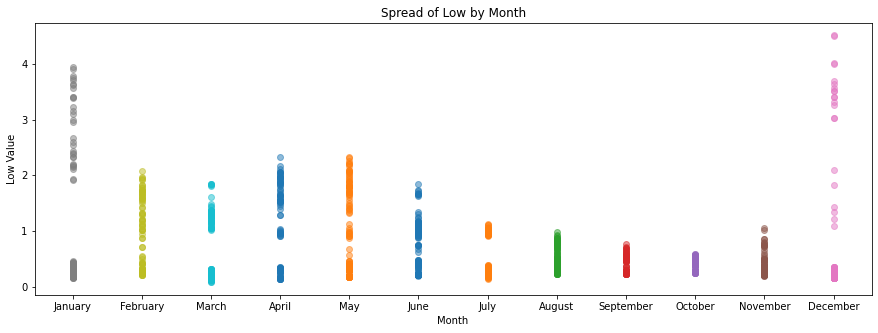

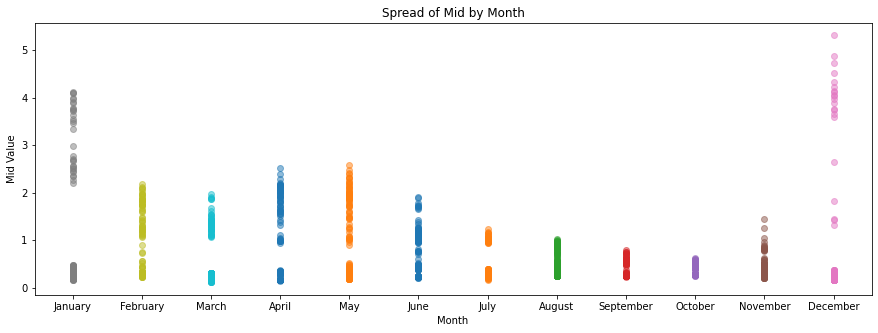

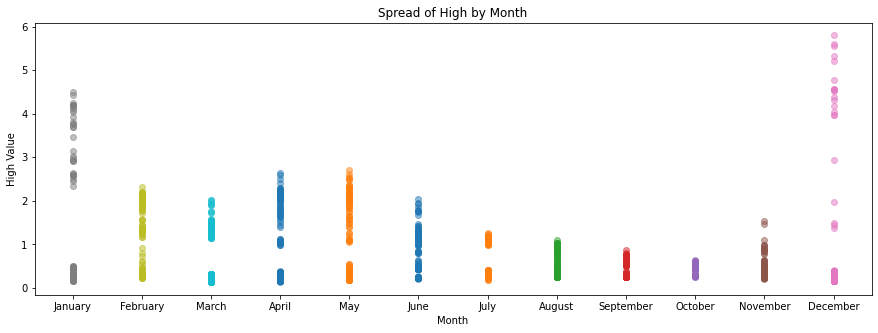

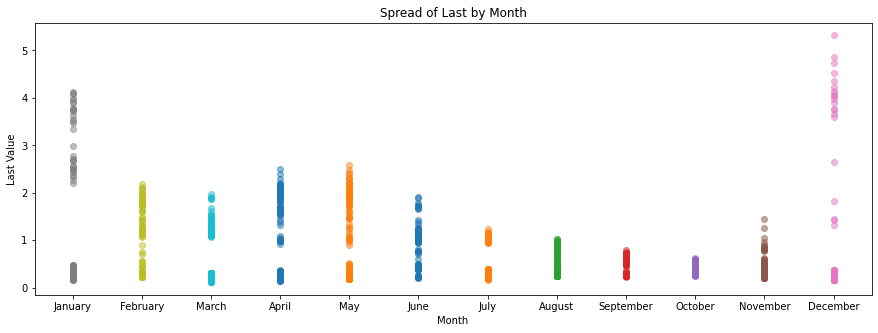

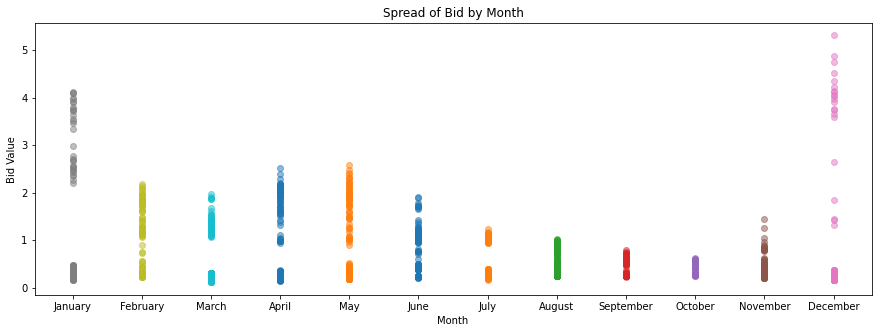

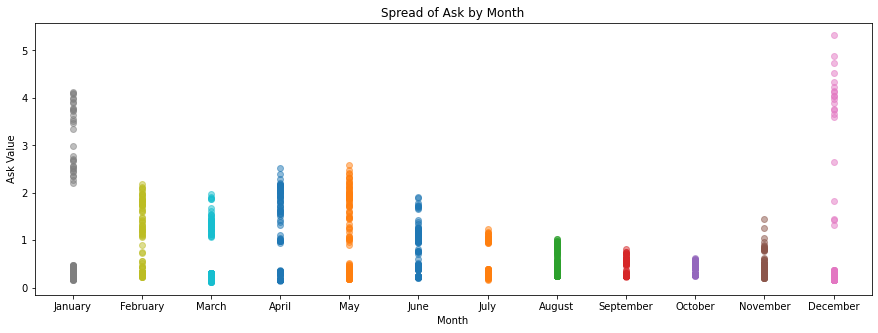

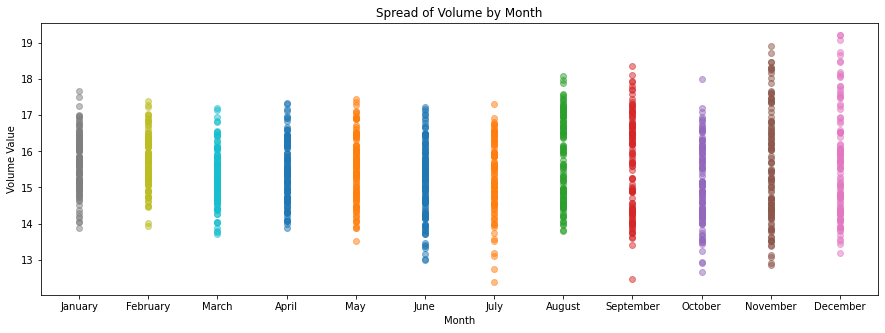

In [8]:
#check for seasonality/trends by month
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
columns = ['Low', 'Mid', 'High', 'Last', 'Bid', 'Ask', 'Volume']

for column in columns:
    plt.figure(figsize=(15,5))
    for month in new_df['Month'].unique():
        plt.scatter('Month', column, data=new_df[new_df['Month']==month], alpha=0.5)
        plt.xticks(ticks=np.arange(1, 13, step=1), labels=months)
        plt.xlabel('Month')
        plt.ylabel(column + ' Value')
        plt.title('Spread of ' + column + ' by Month')
        plt.plot()

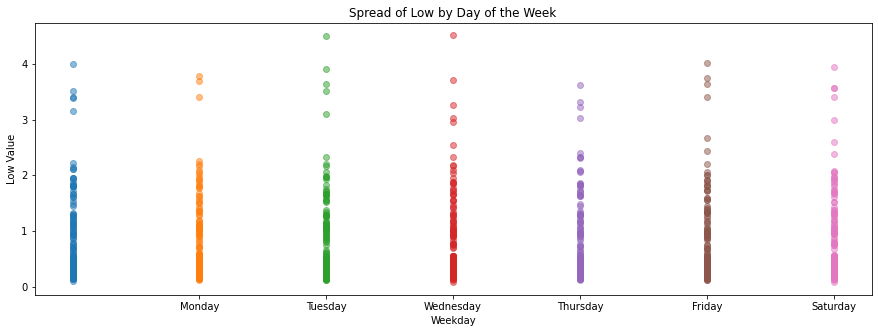

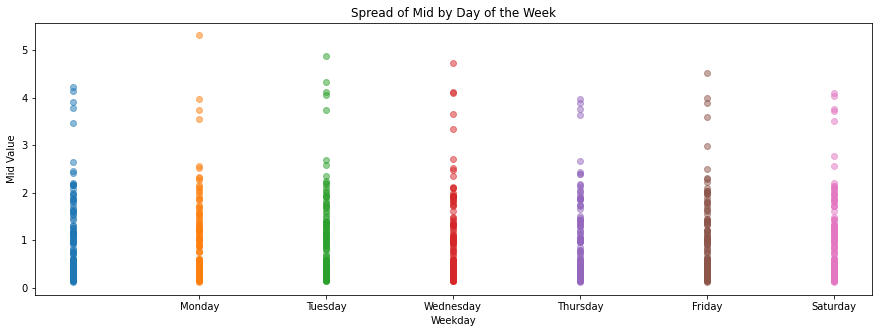

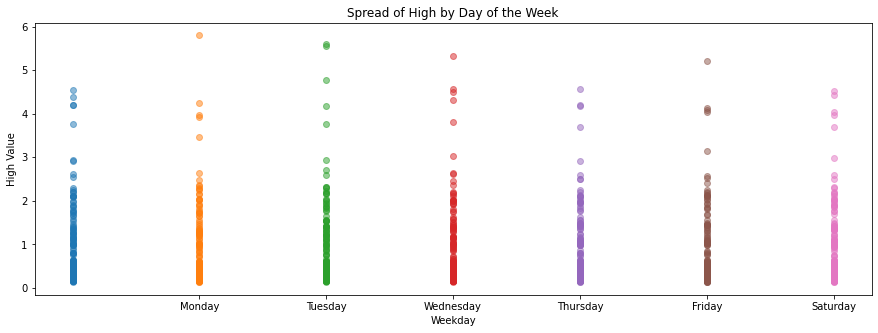

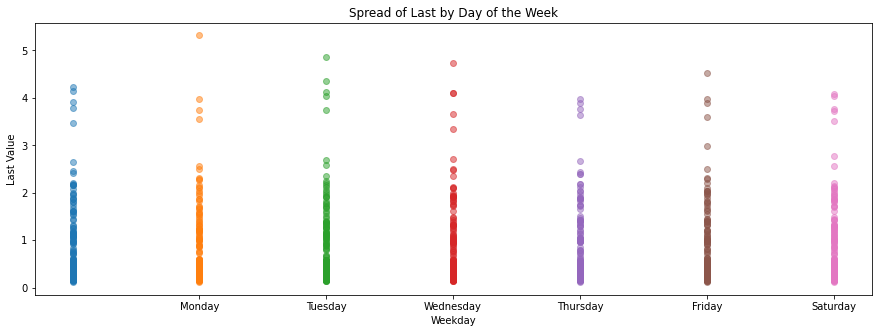

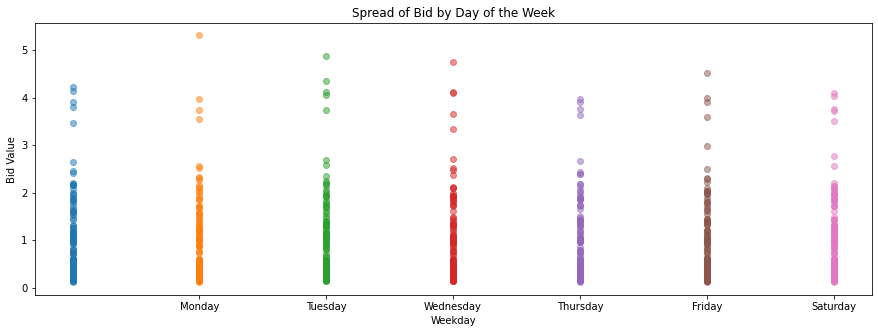

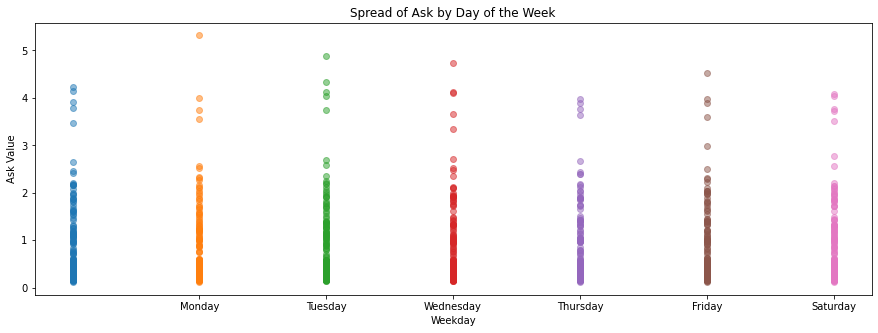

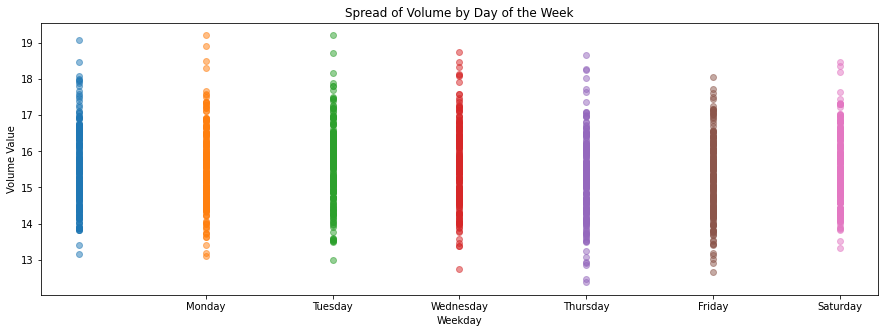

In [9]:
#check for trends/seasonality by week
columns = ['Low', 'Mid', 'High', 'Last', 'Bid', 'Ask', 'Volume']

for column in columns:
    plt.figure(figsize=(15,5))
    for weekday in new_df['Weekday'].unique():
        plt.scatter('Weekday', column, data=new_df[new_df['Weekday']==weekday], alpha=0.5)
        plt.xticks(ticks=np.arange(1, 8, step=1), labels=weekdays)
        plt.xlabel('Weekday')
        plt.ylabel(column + ' Value')
        plt.title('Spread of ' + column + ' by Day of the Week')
        plt.plot()

Save for Volume, most columns of this database have a seasonality such that the highest values are in December and January, with a smaller, secondary peak in April and May, from which the values decline until the end of October.  Volume peaks in November and December with its lowest values in July, September, and October, as well as having less spread in the first half of the year.  For days of the week, Monday, Tuesday, and Wednesday seem to have the highest values, although Low doesn't do as well on Mondays as the other columns do.

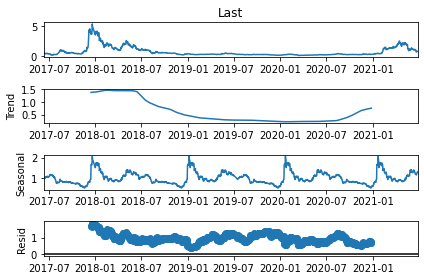

In [10]:
#checking decomposition to look for trends and patterns
y = new_df['Last']

decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative', period=365)
decomposition.plot()
plt.show()

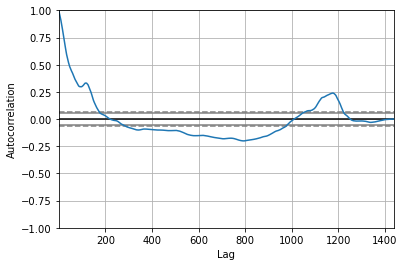

In [11]:
autocorrelation_plot(y)
plt.show()

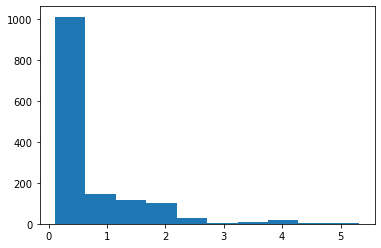

In [12]:
#checking for gaussian noise
plt.hist(y)
plt.show()

In [13]:
#check for stationarity (<0.05 is nonstationary)
print(kpss(y, 'c', nlags='auto')[1])

0.01


C:\Users\rlybb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


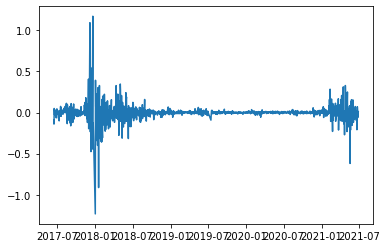

In [14]:
#autocorrelation for stationarity
y_diff = y.diff().dropna()
plt.plot(y_diff)
plt.show()

In [15]:
print(kpss(y_diff, 'c', nlags='auto')[1])

0.1


C:\Users\rlybb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


So it looks like the original data is not stationary, which makes sense for a stock market since the values are constantly shifting as people buy and sell stocks and as the economy shifts.  The autocorrelation is stationary though, and that's enough to run predictions on.

In [16]:
#save dataframe
new_df.to_json('BITFINEX/IOTUSD_EDA.json')